<a href="https://colab.research.google.com/github/aromaldev/OCR-Malayalam/blob/master/classification/deeplearning/Alex_Net_with_SVM_as_Final_Layer_for_122_classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Alex Net with SVM as Classification Layer

Ajay James, Manjusha J, Chandran Saravanan, "Malayalam Handwritten Character Recognition Using AlexNet Based Architecture", *Indonesian Journal of Electrical Engineering and Informatics (IJEEI)*,2018
ISSN 2089-3272, [DOI: 11591/ijeei.v6i4.518.](https://doi.org/10.11591/ijeei.v6i4.518)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!nvidia-smi

Thu Jun 24 00:47:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.regularizers import l2
import os
import random

#### Dataset Generators

In [5]:
base_dir = 'dataset'
img_height = 227
img_width = 227
dim = 3
num_epochs=20
batch_size = 128
shape=(img_height,img_width)
input_shape=(img_height,img_width,dim)
num_of_classes=122


In [5]:
! tar -x -f /content/drive/MyDrive/dataset/handwritten_dataset.tar.xz
!mv augmented+original\ scanned dataset
!rm -r dataset/100
! rm -r dataset/76

In [ ]:
#@title Reading complete dataset (Alternate Method)

"""
train_generator = image_dataset_from_directory(
    './dataset',
    image_size=shape,
    batch_size=batch_size,
    color_mode='rgb',
    label_mode='categorical',
    shuffle=True,
    subset='training',
    seed=123,
    validation_split=0.2
)

val_generator = image_dataset_from_directory(
    './dataset',
    image_size=shape,
    batch_size=batch_size,
    color_mode='rgb',
    label_mode='categorical',
    shuffle=True,
    subset='validation',
    seed=123,
    validation_split=0.2
)"""

In [8]:
file_list = []
#img_per_class =2000

for directory,sub_dir,file_names in os.walk(base_dir):
    if sub_dir != []:
        class_names = sub_dir
    i=0
    for file in file_names:
        if  (file.endswith('.jpg') or file.endswith('.JPG')):
            file_list.append(os.path.join(directory,file))
            i+=1
    if i!=0:
        #print(f"{i} Images from : {directory}")
        pass


random.Random(58).shuffle(file_list)

class_names.sort()
image_count =len(file_list)

print(f'Number of images : {image_count}')
assert len(class_names) == num_of_classes
print(f'Image Per class : {len(file_list)/num_of_classes}')
dataset = tf.data.Dataset.from_tensor_slices(file_list)


Number of images : 502228
Image Per class : 4116.622950819672


In [7]:
print(class_names)

['1', '10', '101', '102', '103', '104', '105', '106', '107', '108', '109', '11', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '12', '120', '121', '122', '123', '124', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']


In [6]:
def get_label (file_name):
    parts = tf.strings.split(file_name,os.path.sep)
    one_hot = parts[-2] == class_names
    return one_hot

def decode_image(img_file,image_type=None,resize_shape=None, channels=0):
    if image_type == 'jpeg' or image_type == 'jpg':
        img_decoded = tf.image.decode_jpeg(img_file,channels=channels)
    elif image_type == 'png':
        img_decoded = tf.image.decode_png(img_file,channels=channels)
    else:
        img_decoded = tf.image.decode_image(img_file,channels=channels)
    
    if (image_type in ['jpeg','jpg', 'png']) and resize_shape != None:
        img_decoded = tf.image.resize(img_decoded,resize_shape,method='lanczos3')
    return img_decoded

def process_path(file_name):
    label = get_label(file_name)
    
    #Load the raw data
    img = tf.io.read_file(file_name)
    img = decode_image(img,'jpeg',resize_shape=shape,channels=dim)
    
    return img,label

In [9]:
AUTO = tf.data.AUTOTUNE
dataset_img = dataset.map(process_path,num_parallel_calls=AUTO)

val_size = int(image_count * 0.2)
train_ds_img = dataset_img.skip(val_size)
test_ds_img  = dataset_img.take(val_size)

print(f"Number of Training images: {tf.data.experimental.cardinality(train_ds_img).numpy()}")
print(f"Number of Validataion images: {tf.data.experimental.cardinality(test_ds_img).numpy()}")

print(f"Batch size = {batch_size}")
train_batchs = train_ds_img.batch(batch_size)
test_batchs = test_ds_img.batch(batch_size)
print (f"Number of Training batchs: {tf.data.experimental.cardinality(train_batchs).numpy()}")
print (f"Number of Testing batchs: {tf.data.experimental.cardinality(test_batchs).numpy()}")

Number of Training images: 401783
Number of Validataion images: 100445
Batch size = 128
Number of Training batchs: 3139
Number of Testing batchs: 785


#### Model Architecture

In [13]:
model=keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3)),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(num_of_classes,kernel_regularizer=tf.keras.regularizers.l2(0.01)) # multiclass svm
])

In [14]:
model.compile(
    loss='squared_hinge',
    optimizer=tf.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']    
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 55, 55, 128)       46592     
_________________________________________________________________
batch_normalization (BatchNo (None, 55, 55, 128)       512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 256)       819456    
_________________________________________________________________
batch_normalization_1 (Batch (None, 27, 27, 256)       1024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 9, 256)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 256)         5

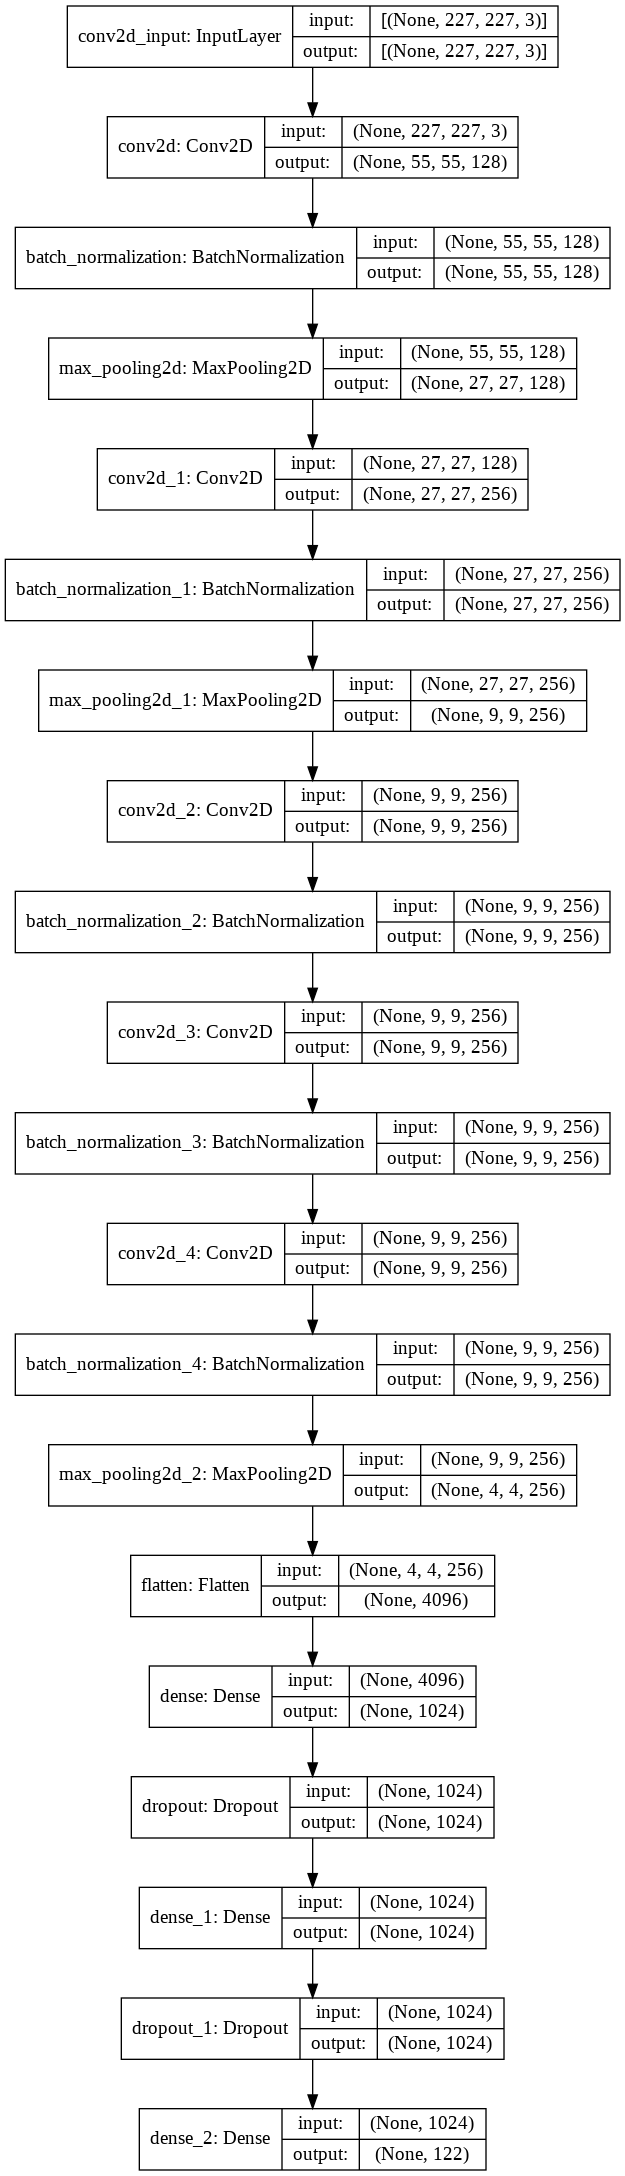

In [51]:
tf.keras.utils.plot_model(
    model,
    to_file="/content/drive/MyDrive/models/alexmodelsvm5.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

#### Model Training

In [16]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

checkpoint_filepath = '/content/drive/MyDrive/models/checkpoint_alexmodelsvm5'
chk = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [17]:
history = model.fit(
    train_batchs,
    epochs=num_epochs,
    validation_data=test_batchs,
    callbacks=[es,chk],
    batch_size=batch_size
)

model.save('/content/drive/MyDrive/models/alexmodelsvm5.h5')

Epoch 1/20
3139/3139 [==============================] - 808s 228ms/step - loss: 0.0962 - accuracy: 0.3652 - val_loss: 0.0433 - val_accuracy: 0.3638
Epoch 2/20
3139/3139 [==============================] - 772s 222ms/step - loss: 0.0187 - accuracy: 0.8716 - val_loss: 0.0329 - val_accuracy: 0.5006
Epoch 3/20
3139/3139 [==============================] - 774s 223ms/step - loss: 0.0145 - accuracy: 0.9356 - val_loss: 0.0337 - val_accuracy: 0.5550
Epoch 4/20
3139/3139 [==============================] - 774s 223ms/step - loss: 0.0132 - accuracy: 0.9547 - val_loss: 0.0168 - val_accuracy: 0.9078
Epoch 5/20
3139/3139 [==============================] - 774s 223ms/step - loss: 0.0124 - accuracy: 0.9651 - val_loss: 0.0317 - val_accuracy: 0.6956
Epoch 6/20
3139/3139 [==============================] - 773s 222ms/step - loss: 0.0118 - accuracy: 0.9706 - val_loss: 0.0364 - val_accuracy: 0.5473
Epoch 7/20
3139/3139 [==============================] - 774s 223ms/step - loss: 0.0109 - accuracy: 0.9779 - val_

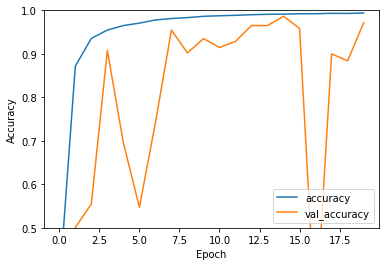

In [18]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')


In [19]:
test_loss, test_acc = model.evaluate(test_batchs, verbose=2)

785/785 - 120s - loss: 0.0114 - accuracy: 0.9715


In [20]:
print(test_acc)

0.9714968204498291


In [10]:
model = tf.keras.models.load_model('/content/drive/MyDrive/models/alexmodelsvm5.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 55, 55, 128)       46592     
_________________________________________________________________
batch_normalization (BatchNo (None, 55, 55, 128)       512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 256)       819456    
_________________________________________________________________
batch_normalization_1 (Batch (None, 27, 27, 256)       1024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 9, 256)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 256)         5

#### Getting Class Names


In [44]:
#@title Get the charecter encoding TL;DR


mal_unicode_dict = {
    1:  ("05",),
    2:  ("16",),
    3:  ("2e","4d","2e"),
    4:  ("2e","4d","32"),
    5:  ("2f","4d","2f"),
    6:  ("32","4d","32"),
    7:  ("35","4d","35"),
    8:  ("36","4d","36"),
    9:  ("36","4d","32"),
    10: ("36","4d","1a"),
    11: ("37","4d","1f"),
    12: ("38","4d","32"),
    13: ("17",),
    14: ("38","4d","38"),
    15: ("38","4d","31","4d","31"),
    16: ("38","4d","27"),
    17: ("38","4d","25"),
    18: ("39","4d","2e"),
    19: ("39","4d","28"),
    20: ("39","4d","32"),
    21: ("33","4d","33"),
    22: ("31","4d","31"),
    23: ("7b",),
    24: ("18",),
    25: ("7d",),
    26: ("7c",),
    27: ("7e",),
    28: ("7a",),
    29: ("28","4d","27"),
    30: ("19",),
    31: ("1a",),
    32: ("1b",),
    33: ("1c",),
    34: ("1d",),
    35: ("1e",),
    36: ("1f",),
    37: ("06",),
    38: ("20",),
    39: ("21",),
    40: ("22",),
    41: ("23",),
    42: ("24",),
    43: ("25",),
    44: ("26",),
    45: ("27",),
    46: ("28",),
    47: ("2a",),
    48: ("07",),
    49: ("2b",),
    50: ("2c",),
    51: ("2d",),
    52: ("2e",),
    53: ("2f",),
    54: ("30",),
    55: ("32",),
    56: ("35",),
    57: ("36",),
    58: ("37",),
    59: ("09",),
    60: ("38",),
    61: ("39",),
    62: ("33",),
    63: ("34",),
    64: ("31",),
    65: ("3e",),
    66: ("3f",),
    67: ("40",),
    68: ("41",),
    69: ("42",),
    70: ("0b",),
    71: ("43",),
    72: ("46",),
    73: ("47",),
    74: ("57",),
    75: ("4d",),
    76: ("4d","2f"),
    77: ("4d","30"),
    78: ("4d","35"),
    79: ("15","4d","15"),
    80: ("15","4d","32"),
    81: ("0e",),
    82: ("15","4d","37"),
    83: ("15","4d","24"),
    84: ("17","4d","17"),
    85: ("17","4d","32"),
    86: ("17","4d","28"),
    87: ("17","4d","2e"),
    88: ("19","4d","15"),
    89: ("19","4d","19"),
    90: ("1a","4d","1a"),
    91: ("1a","4d","1b"),
    92: ("0f",),
    93: ("1c","4d","1c"),
    94: ("1e","4d","1a"),
    95: ("1c","4d","1e"),
    96: ("1e","4d","1e"),
    97: ("1f","4d","1f"),
    98: ("21","4d","21"),
    99: ("23","4d","1f"),
    100:("23","4d","21"),
    101:("23","4d","2e"),
    102:("23","4d","23"),
    103:("12",),
    104:("24","4d","24"),
    105:("24","4d","25"),
    106:("24","4d","2d"),
    107:("24","4d","38"),
    108:("24","4d","2e"),
    109:("26","4d","26"),
    110:("26","4d","27"),
    111:("7b","4d","31"),
    112:("28","4d","24"),
    113:("28","4d","26"),
    114:("15",),
    115:("28","4d","28"),
    116:("28","4d","2e"),
    117:("28","4d","25"),
    118:("2a","4d","2a"),
    119:("2a","4d","32"),
    120:("2c","4d","2c"),
    121:("2c","4d","32"),
    122:("2c","4d","27"),
    123:("2c","4d","26"),
    124:("2e","4d","2a")
}

def get_char_encodings(mal_dict = mal_unicode_dict):
    prefix = "0x0d"
    mal_char_dict = {}
    for x in mal_dict.keys():
        char_tuple = mal_dict[x]
        char = [prefix + a for a in char_tuple]
        chr_str = ''.join([chr(int(a,16)) for a in char])   
        #print(f"{x:03} : {chr_str:6}{str(char)}")
        
        mal_char_dict[str(x)] = chr_str#.encode('utf-8')
    return mal_char_dict


In [45]:
mal_dict = get_char_encodings()

print([mal_dict[x] for x in class_names])

['അ', 'ശ്ച', 'ണ്മ', 'ണ്ണ', 'ഒ', 'ത്ത', 'ത്ഥ', 'ത്ഭ', 'ത്സ', 'ത്മ', 'ദ്ദ', 'ഷ്ട', 'ദ്ധ', 'ൻ്റ', 'ന്ത', 'ന്ദ', 'ക', 'ന്ന', 'ന്മ', 'ന്ഥ', 'പ്പ', 'പ്ല', 'സ്ല', 'ബ്ബ', 'ബ്ല', 'ബ്ധ', 'ബ്ദ', 'മ്പ', 'ഗ', 'സ്സ', 'സ്റ്റ', 'സ്ധ', 'സ്ഥ', 'ഹ്മ', 'ഹ്ന', 'ഖ', 'ഹ്ല', 'ള്ള', 'റ്റ', 'ൻ', 'ഘ', 'ൽ', 'ർ', 'ൾ', 'ൺ', 'ന്ധ', 'മ്മ', 'ങ', 'ച', 'ഛ', 'ജ', 'ഝ', 'ഞ', 'ട', 'ആ', 'ഠ', 'ഡ', 'മ്ല', 'ഢ', 'ണ', 'ത', 'ഥ', 'ദ', 'ധ', 'ന', 'പ', 'ഇ', 'ഫ', 'യ്യ', 'ബ', 'ഭ', 'മ', 'യ', 'ര', 'ല', 'വ', 'ശ', 'ഷ', 'ഉ', 'ല്ല', 'സ', 'ഹ', 'ള', 'ഴ', 'റ', 'ാ', 'ി', 'ീ', 'ു', 'ൂ', 'വ്വ', 'ഋ', 'ൃ', 'െ', 'േ', 'ൗ', '്', '്ര', '്വ', 'ക്ക', 'ശ്ശ', 'ക്ല', 'എ', 'ക്ഷ', 'ക്ത', 'ഗ്ഗ', 'ഗ്ല', 'ഗ്ന', 'ഗ്മ', 'ങ്ക', 'ങ്ങ', 'ശ്ല', 'ച്ച', 'ച്ഛ', 'ഏ', 'ജ്ജ', 'ഞ്ച', 'ജ്ഞ', 'ഞ്ഞ', 'ട്ട', 'ഡ്ഡ', 'ണ്ട']


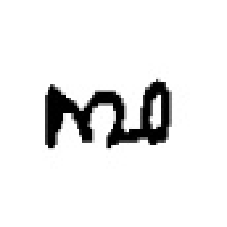

In [52]:
img = tf.keras.preprocessing.image.load_img('/content/dataset/117/102.jpg'
    , color_mode='rgb', target_size=shape,interpolation='nearest')

h = []
array = tf.keras.preprocessing.image.img_to_array(img)
h.append(array)
h = np.array(h)

img

In [53]:
print(f"Predicted : {mal_dict[class_names[model.predict(h).argmax()]]}")

Predicted : ന്ഥ


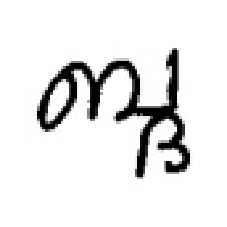

In [54]:
img = tf.keras.preprocessing.image.load_img('/content/dataset/123/1035.jpg'
    , color_mode='rgb', target_size=shape,interpolation='nearest')

h = []
array = tf.keras.preprocessing.image.img_to_array(img)
h.append(array)
h = np.array(h)

img

In [55]:
print(f"Predicted : {mal_dict[class_names[model.predict(h).argmax()]]}")

Predicted : ബ്ദ


#### Testing

In [20]:
from sklearn.metrics import classification_report,ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

In [15]:
y_predict = model.predict(test_batchs)

Y_test = []
y_act_predict = np.argmax(y_predict,axis=1)

print(y_act_predict.shape)
for img,label in test_ds_img.as_numpy_iterator():
    Y_test.append(np.argmax(label))
Y_test = np.array(Y_test)
print(Y_test.shape)

assert Y_test.shape== y_act_predict.shape

(100445,)
(100445,)


##### Classification Report

In [27]:
print(classification_report(Y_test,y_act_predict))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98       918
           1       1.00      1.00      1.00      1062
           2       1.00      0.96      0.98       446
           3       0.99      0.99      0.99      1025
           4       0.99      1.00      0.99       896
           5       1.00      0.97      0.98      1065
           6       0.99      0.99      0.99      1201
           7       0.98      1.00      0.99      1060
           8       0.90      0.94      0.92       581
           9       0.89      0.98      0.93       512
          10       0.90      0.97      0.93      1217
          11       0.98      0.99      0.98       529
          12       0.99      0.99      0.99       506
          13       0.99      1.00      1.00       458
          14       0.98      0.99      0.99      1245
          15       1.00      0.98      0.99       522
          16       1.00      0.99      0.99       914
          17       0.99    

##### Confusion Matrix

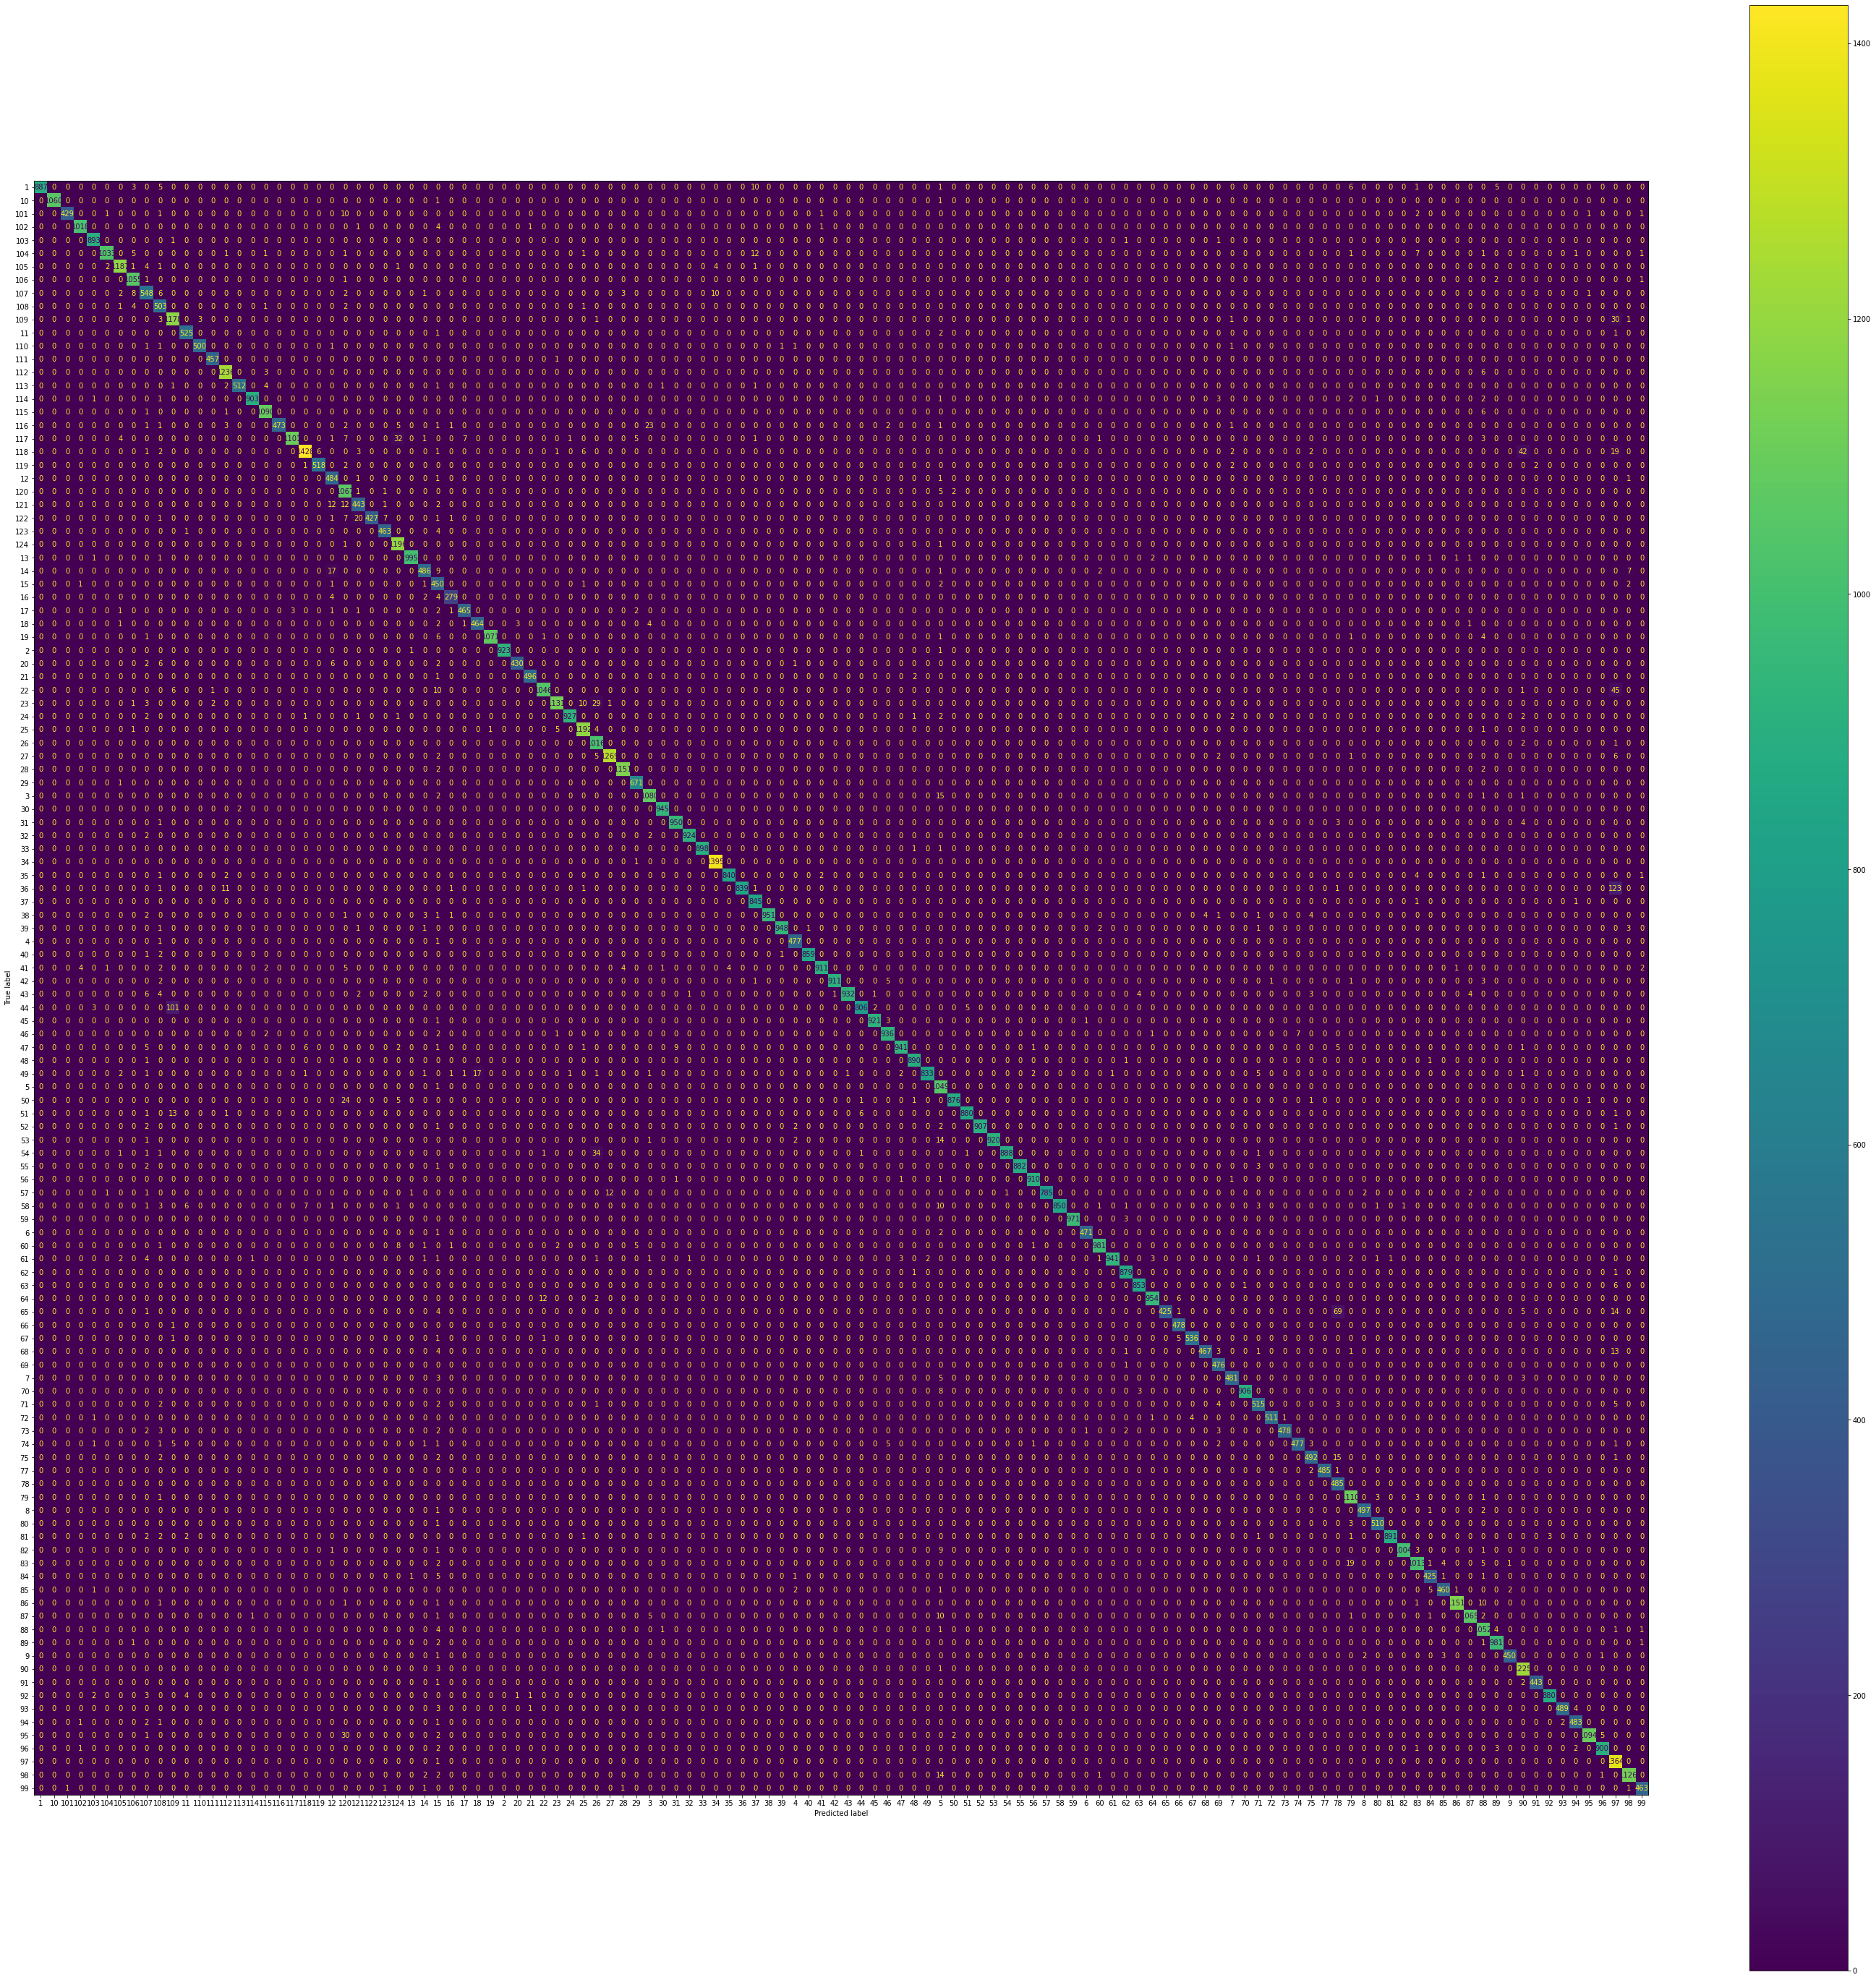

In [22]:
con_mat = confusion_matrix(Y_test,y_act_predict)
fig, ax = plt.subplots(figsize=(50, 50))
ConfusionMatrixDisplay(con_mat,class_names).plot(ax=ax,values_format = 'd')